# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn import tree

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree

# 2. Import Dataset

In [4]:
data_train=pd.read_csv("train.csv")
data_test=pd.read_csv("test.csv")

# 3. Data Exploration

In [5]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data_train.shape

(891, 12)

In [7]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
data_train.shape

(891, 12)

In [9]:
data_test.shape

(418, 11)

#### Training dataset has 891 samples with 11 features and 1 target label in column 'Survived'

#### Test dataset has 418 samples with same 11 features as training set. And as expected it doesn't have survived column

#### Some columns have missing values

In [10]:
data_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### 1. There are 5 object features: Name, Sex, Ticket, Cabin and Embarked.

    Two of them: Cabin and Ticket are mixed type (numbers+ string)
    Sex is binary category
    Embarked is category
    Name is text
#### 2. There are 6 numeric features: Pclass, Age, PassengerID, SibSp, Parch, Fare.

    Age and Fare are continuous
    Pclass is ordinal category
    SibSp and Parch are discrete ordinal
#### 3. Target: Survived is binary categorical

# 4. Explore Target Variable

In [11]:
# Extract target variable from train set
label = data_train['Survived']

In [12]:
# Check for unique values
label.unique()

array([0, 1], dtype=int64)

In [13]:
# Check for mission values
if(label.isna().sum()==0):
    print("No Missing Values")
else:
    print(label.isnull().sum(), 'missing values found in dataset')

No Missing Values


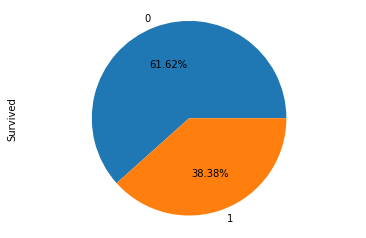

In [14]:
# Pie Plot to Visualise the Target Variable
label.value_counts().plot.pie(autopct='%1.2f%%')
plt.axis('equal')
plt.show()

- Survived is binary category with 2 possible values: 1 - if person survived and 0 - if not
- 61.6% of people did not survive in titanic catastrophy

# 5. Explore and Engineer Features

## Missing Value Theory

In the dataset Age, Embarked, Fare and Cabin features have missing values.  
There are miltiple ways to deal with missing values in dataset and chosen strategy highly depends on type feature type, amount of missing values, size of dataset and etc.  

Possible solutions to deal with missing values in continues variables:

1. Complete Case Analysis CCA (discard observations where any value is missing in any variable) 
    -doesn't work if there are many features missing or on small datasets
2. Mean and median imputation (substitute missing values with mean feature value (for Gaussian features) and median (if a variable is not Gaussian) 
    - normally good strategy if data is missing completely at random
    - but if there is a dependency between why data is missing and target it is better to additionally create a separate variable to capture NAs
    - changes the original distribution of variable and can distort covariance with other variables --> if too much can influence prediction in a negative way
3. Random sampling imputation (to fill NAs - take a random observation from available observation)
    - preserves the original distribution of data, but can create randomness - treatment of the same sample differently or unfair
4. Adding a separate variable to capture NAs 
    - useful in situations when data is not missing at random and there is some connection on why data is missing with a target or other variables
    - expands feature space as creates an additional feature 
5. End of distribution imputation (replace NAs with values that are at the far end of the distribution)
    - shows the importance of missingness
    - but if missingness is not important can mask predictive power and distorts the original distribution
6. Arbitrary value imputation (substitute with value away from other values in the variable -999, 999)
    - captures the importance of missing value
    - but creates outlier (it doesn't matter for trees)
7. Build a model to impute missing values: KNN, linear regression, etc.
    - a very good estimate of missing data
    - but it can be a problem because prediction usually is too good and doesn't match reality

Possible solutions to deal with missing values in categorical variables: 
1. CCA 
    - for pros and cons refer above
2. Random sample imputation
3. Adding a separate variable to capture NAs
4. Adding a separate category to capture NAs

For more details on this topic refer to:   
1. [Missing-data imputation](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)
2. [How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)

## 5.1 Finding the Missing Values

In [15]:
print("Missing Values in Train Dataset")
print(data_train.isna().sum())
print("==================================================================")
print("Missing Values in Test Dataset")
print(data_test.isna().sum())

Missing Values in Train Dataset
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing Values in Test Dataset
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [16]:
# Check how many unique values each feature has:
data_train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

- Features PassengerId, Name, Ticket and Cabin have a lot of unique values
- Age and Fare have a lot of unique values as well, but it is natural for continues numeric features
- Sex in binary category
- Pclass is ordinal category
- Embarked is non-ordinal category
- SibSp and Parch are discreat counts

# 5.2 Filling the Missing Values

## 5.2.1 Fare and Embarked

In [17]:
print('Amount of missing data in Embarked for train:',data_train.Embarked.isnull().sum())
print('Amount of missing data in Embarked for test:', data_test.Embarked.isnull().sum())
print("--------------------------------------------------")
print('Amount of missing data in Fare for train:', data_train.Fare.isnull().sum())
print('Amount of missing data in Fare for test:',data_test.Fare.isnull().sum())

Amount of missing data in Embarked for train: 2
Amount of missing data in Embarked for test: 0
--------------------------------------------------
Amount of missing data in Fare for train: 0
Amount of missing data in Fare for test: 1


##### Amount of missing data in both columns is insignificant. Fill them with most frequent value for Embarked and median value for Fare

In [18]:
data_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
data_train["Embarked"]=data_train["Embarked"].fillna("S")

In [20]:
data_train["Fare"]=data_train["Fare"].fillna(data_train["Fare"].median())
data_test["Fare"]=data_test["Fare"].fillna(data_test["Fare"].median())

## 5.2.2 Age

In [21]:
data_train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [22]:
# check variable Age for missing values:
print('Amount of missing data in Age for train:',data_train.Age.isnull().sum())
print('Amount of missing data in Age for test:',data_test.Age.isnull().sum())

Amount of missing data in Age for train: 177
Amount of missing data in Age for test: 86


In [23]:
# 1. create feature to show rows with missing values of age:
data_train["Age_NA"]=np.where(data_train.Age.isnull(),1,0)
data_test["Age_NA"]=np.where(data_test.Age.isnull(),1,0)

0    714
1    177
Name: Age_NA, dtype: int64


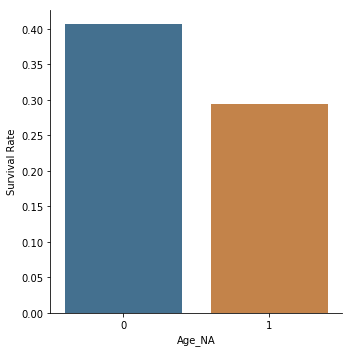

In [24]:
# 2. visualize Age_NA vs survival rate
print(data_train["Age_NA"].value_counts())
sns.catplot(x='Age_NA',y='Survived', data=data_train, saturation=0.5,kind="bar", ci=None)
plt.ylabel("Survival Rate")
plt.show()

##### We can see that the survival rate of people whose Age is given is Higher than the survival rate of the people with Age not given

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


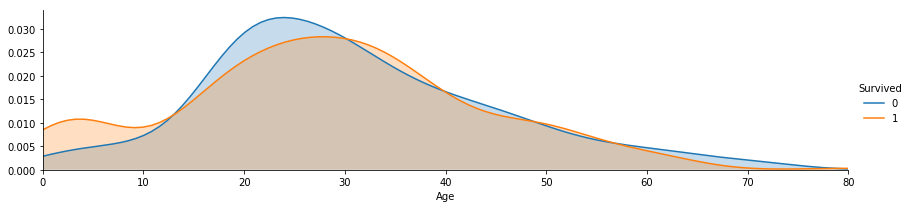

In [25]:
# 3. plot distribution of available Age vs survival rate
a = sns.FacetGrid(data_train, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data_train['Age'].max()))
a.add_legend()

##### data is a almost normal, we will fill missing values with mean

In [26]:
# create feature where missing age is imputed with mean of age values that are not missing
data_train['Age_mean'] =np.where(data_train.Age.isnull(), data_train['Age'].mean(), data_train['Age'])
data_test['Age_mean'] =np.where(data_test.Age.isnull(), data_test['Age'].mean(), data_test['Age'])

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


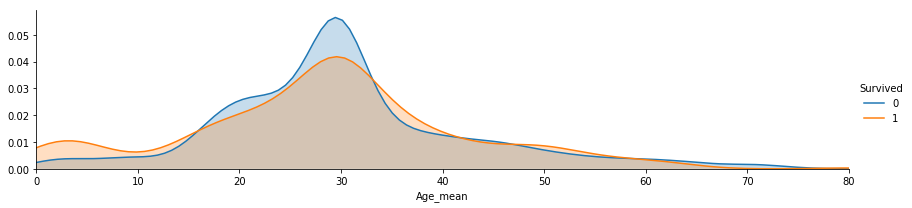

In [27]:
# plot distribution of available Age_mean vs survival rate
a = sns.FacetGrid(data_train, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age_mean', shade= True )
a.set(xlim=(0 , data_train['Age_mean'].max()))
a.add_legend()


##### As expected, after we filled missing values with the mean disctribution of Age variable has changed.
To avoid this phenomenon we will use prediction model to predict missing values of Age from other available variables.

## 5.3 Features with High Number of Unique Values

Features PassengerId, Name, Ticket and Cabin are features with high cardinality. Normally this features can be dropped from dataset, however, sometimes they have usefull information hidden, and before dropping them, we need to extract this information.  
Hypothesis:
1. PassengerId can be dropped as it is unique and represents ID for each passenger. Hypothesis: there is no hidden information
2. Cabin:
    - cabin_type (letter before number) infomation is most probably related with deck. Hypothesis: People on lower deck could potentially have less probability to survive. 
    - Cabin has also a lot of missing values. This can be also connected with survival rate. Hypothesis: people who did not survive could not provide information about cabin
3. Ticket:
    - ticket_type could potentantially be connected with survival rate. Hypothesis: ticket type can have hidden information about passenger status
4. Name:
    - title. Hypothesis: can have hidden information about passenger status. For example married women could have more chances to survive than single man
    - family survival rate: a lot of people survived from specific family increases chances of person from same family to survive.

# 5.3.1 Drop Passenger ID

In [28]:
data_train=data_train.drop(columns=["PassengerId"],axis=1)
data_test=data_test.drop(columns=["PassengerId"],axis=1)

In [29]:
data_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_NA,Age_mean
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,22.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,38.0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,26.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,35.0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,35.0


In [30]:
data_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_NA,Age_mean
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,34.5
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,47.0
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,62.0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,27.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,22.0


## 5.3.2 Ticket

In [31]:
#create function that takes ticket feature and returns list of ticket_types
def ticket_sep(data_ticket):
    ticket_type = []

    for i in range(len(data_ticket)):

            ticket =data_ticket.iloc[i]

            for c in string.punctuation:
                ticket = ticket.replace(c,"")
                splited_ticket = ticket.split(" ")   
            if len(splited_ticket) == 1:
                ticket_type.append('NO')
            else: 
                ticket_type.append(splited_ticket[0])
    return ticket_type 
# for train data create new column with ticket_type:
data_train["ticket_type"] = ticket_sep(data_train.Ticket)
# for test data create new column with ticket_type:
data_test["ticket_type"]= ticket_sep(data_test.Ticket)
# check how many samples are there for each ticket type and visualize:
print(data_train["ticket_type"].value_counts())

NO         665
PC          60
CA          41
A5          21
SOTONOQ     15
STONO       12
WC          10
A4           7
SCPARIS      7
STONO2       6
SOC          6
C            5
FCC          5
SCParis      4
SCAH         3
PP           3
WEP          3
SOPP         3
SOTONO2      2
SWPP         2
PPP          2
Fa           1
SCA4         1
FC           1
CASOTON      1
AS           1
SCOW         1
SP           1
SOP          1
SC           1
Name: ticket_type, dtype: int64


##### we will put all ticket types in train data that have less than or equal to 15 samples into separate type 'OTHER_T'

In [32]:
# for those types that have less than 15 samples in training set, assign type to 'OTHER':

for t in data_train['ticket_type'].unique():
    if len(data_train[data_train['ticket_type']==t]) < 16:
        data_train.loc[data_train.ticket_type ==t, 'ticket_type'] = 'OTHER_T'
       
    
for t in data_test['ticket_type'].unique():
    if t not in data_train['ticket_type'].unique():
        data_test.loc[data_test.ticket_type ==t, 'ticket_type'] = 'OTHER_T'
        
print(data_train['ticket_type'].unique())
print(data_test['ticket_type'].unique())

['A5' 'PC' 'OTHER_T' 'NO' 'CA']
['NO' 'OTHER_T' 'PC' 'A5' 'CA']


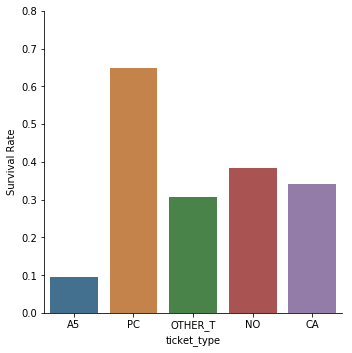

In [33]:
# visualize ticket_type vs survival rate
sns.catplot(x = 'ticket_type', y = 'Survived', data = data_train,saturation=0.5,kind="bar", ci=None)
plt.ylim(0,0.8)
plt.ylabel("Survival Rate")
plt.show()

From the graph it is visible that there is some pattern in probability of survival based on ticket type:
- Passengers with PC ticket_type have higher probability to survive, and with A5- lower probability to survive

In [34]:
# drop Ticket from dataset:

data_train = data_train.drop(['Ticket'], axis=1)
data_test = data_test.drop(['Ticket'], axis=1)

# 5.3.3 Cabin

In [35]:
print('Missing values in Train set:', data_train.Cabin.isnull().sum())
print('Missing values in Test set:', data_test.Cabin.isnull().sum())


Missing values in Train set: 687
Missing values in Test set: 327


In [36]:
data_train.Cabin[:10]

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

Variable in column Cabin has following structure:  
    - deck : Letter in front of number 
    - cabin number 
Deck probably has impact on survival rate. 

In [37]:
#create function that takes cabin from dataset and extracts cabin type for each cabin that is not missing.
# If cabin is missing, leaves missing value:

def cabin_sep(data_cabin):
    cabin_type = []

    for i in range(len(data_cabin)):

            if data_cabin.isnull()[i] == True: 
                cabin_type.append('NaN') 
            else:    
                cabin = data_cabin[i]
                cabin_type.append(cabin[:1]) 
            
    return cabin_type
# apply cabin sep on test and train set:
data_train['cabin_type'] = cabin_sep(data_train.Cabin)
data_test['cabin_type'] = cabin_sep(data_test.Cabin)
# visualize cabin_type vs survival rate:
print(data_train["cabin_type"].value_counts())

NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: cabin_type, dtype: int64


In [38]:
# for those types that have less than 15 samples in training set, assign type to 'OTHER':

for t in data_train['cabin_type'].unique():
    if len(data_train[data_train['cabin_type']==t]) <= 15:
        data_train.loc[data_train.cabin_type ==t, 'cabin_type'] = 'OTHER'
       
    
for t in data_test['cabin_type'].unique():
    if t not in data_train['cabin_type'].unique():
        data_test.loc[data_test.cabin_type ==t, 'cabin_type'] = 'OTHER'
        
print(data_train['cabin_type'].unique())
print(data_test['cabin_type'].unique())

['NaN' 'C' 'E' 'OTHER' 'D' 'B']
['NaN' 'B' 'E' 'OTHER' 'C' 'D']


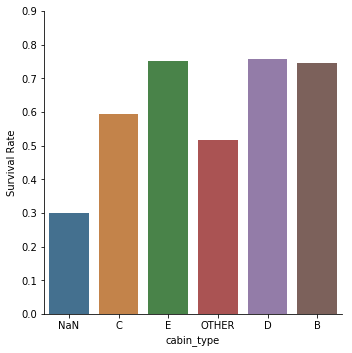

In [39]:
# visualize cabin_type vs survival rate
sns.catplot(x = 'cabin_type', y = 'Survived', data = data_train,saturation=0.5,kind="bar", ci=None)
plt.ylim(0,0.9)
plt.ylabel("Survival Rate")
plt.show()

In [40]:
# drop cabin from dataset:

data_train = data_train.drop(['Cabin'], axis=1)
data_test = data_test.drop(['Cabin'], axis=1)

# 5.3.4 Name

In [41]:
data_train.Name[:10]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

- Feature 'Name' has following structure:   
- Family name--> "," --> Title --> Name --> "(" --> some name in bracket.  
- Separate this into new features and drop Name after that

In [42]:
# Create function that take name and separates it into title, family name and deletes all puntuation from name column:
def name_sep(data):
    families=[]
    titles = []
    new_name = []
    #for each row in dataset:
    for i in range(len(data)):
        name = data.iloc[i]
        # extract name inside brakets into name_bracket:
        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(",")[0]
        title = name_no_bracket.split(",")[1].strip().split(" ")[0]
        
        #remove punctuations accept brackets:
        for c in string.punctuation:
            name = name.replace(c,"").strip()
            family = family.replace(c,"").strip()
            title = title.replace(c,"").strip()
            
        families.append(family)
        titles.append(title)
        new_name.append(name)
            
    return families, titles, new_name    
# apply name_sep on train and test set:
data_train['family'], data_train['title'], data_train['Name']  = name_sep(data_train.Name)
data_test['family'], data_test['title'], data_test['Name'] = name_sep(data_test.Name)
# check how many samples we have for each title and visualize vs survival rate:
print(data_train["title"].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Jonkheer      1
Sir           1
the           1
Capt          1
Don           1
Lady          1
Ms            1
Mme           1
Name: title, dtype: int64


- Put all title in train data that have less than 15 samples into separate type 'OTHER'

In [43]:
# for those types that have less than 15 samples in training set, assign type to 'OTHER':

for t in data_train['title'].unique():
    if len(data_train[data_train['title']==t]) <= 15:
        data_train.loc[data_train.title ==t, 'title'] = 'OTHER'
       
    
for t in data_test['title'].unique():
    if t not in data_train['title'].unique():
        data_test.loc[data_test.title ==t, 'title'] = 'OTHER'
        
print(data_train['title'].unique())
print(data_test['title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'OTHER']
['Mr' 'Mrs' 'Miss' 'Master' 'OTHER']


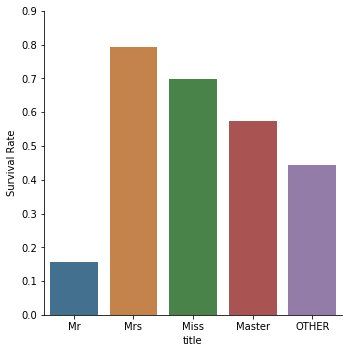

In [44]:
# visualize title vs survival rate:
sns.catplot(x = 'title', y = 'Survived', data = data_train,saturation=0.5,kind="bar", ci=None)
plt.ylim(0,0.9)
plt.ylabel("Survival Rate")
plt.show()

- According to the plot there is definatelly correlation between survival rate and title. For example Mrs and Miss have the same gender, but it is visible that Mrs has higher survival rate than Miss. 
- Logically, as Mrs probably had priorities to board surviving boats because they had children with them.

## 5.3.5 Create a New Variable Family Size

In [45]:
# introduce new column to data called family_size:
data_train['family_size'] = data_train.SibSp + data_train.Parch +1
data_test['family_size'] = data_test.SibSp + data_test.Parch +1

In [46]:
print(data_train['family_size'].unique())
print(data_test['family_size'].unique())

[ 2  1  5  3  7  6  4  8 11]
[ 1  2  3  5  4  6  8  7 11]


In [47]:
data_train.loc[data_train["family_size"]==1,"family_size_grp"]="Singleton"
data_train.loc[(data_train["family_size"]>1)&(data_train["family_size"]<5),"family_size_grp"]="Small Family"
data_train.loc[data_train["family_size"]>4,"family_size_grp"]="Large Family"

print(data_train['family_size_grp'].unique())

data_test.loc[data_test["family_size"]==1,"family_size_grp"]="Singleton"
data_test.loc[(data_test["family_size"]>1)&(data_test["family_size"]<5),"family_size_grp"]="Small Family"
data_test.loc[data_test["family_size"]>4,"family_size_grp"]="Large Family"

print(data_test['family_size_grp'].unique())

['Small Family' 'Singleton' 'Large Family']
['Singleton' 'Small Family' 'Large Family']


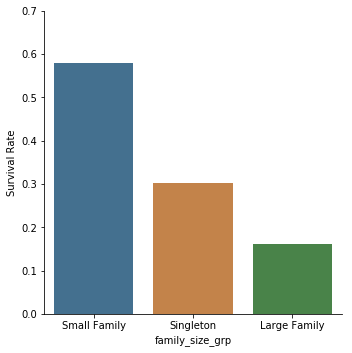

In [48]:
# visualize Family Size Group vs survival rate:
sns.catplot(x = 'family_size_grp', y = 'Survived', data = data_train,saturation=0.5,kind="bar", ci=None)
plt.ylim(0,0.7)
plt.ylabel("Survival Rate")
plt.show()

# 6. Hypothesis Testing

## 6.1 Female and Children have a better chance of survival

In [49]:
data_train["title"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
OTHER      27
Name: title, dtype: int64

In [50]:
data_train.loc[(data_train["title"]=="Miss") | (data_train["title"]=="Mrs") | (data_train["title"]=="Master"),"female_children"]="Yes"
data_train.loc[(data_train["title"]=="Mr") | (data_train["title"]=="OTHER"),"female_children"]="No"

- As both Family_children and Survived are categorical Variable, so we are applying Chi-square test

In [51]:
crosstab = pd.crosstab(data_train['female_children'], data_train['Survived'])
crosstab

Survived,0,1
female_children,,
No,451,93
Yes,98,249


In [52]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")

if(p_val<0.05):
    print("There is a Significant Relationship")

===Chi2 Stat===
265.35408311340825


===Degrees of Freedom===
1


===P-Value===
1.1681500474220461e-59


There is a Significant Relationship


#### Conclusion- There is a significant relationship between a person being Female or Children and having a better chance of survival

## 6.2 Ticket type could potentially be connected with survival rate

In [53]:
crosstab = pd.crosstab(data_train['ticket_type'], data_train['Survived'])
crosstab

Survived,0,1
ticket_type,,
A5,19,2
CA,27,14
NO,410,255
OTHER_T,72,32
PC,21,39


In [54]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")

if(p_val<0.05):
    print("There is a Significant Relationship")

===Chi2 Stat===
28.22901717611941


===Degrees of Freedom===
4


===P-Value===
1.1208328141777033e-05


There is a Significant Relationship


#### Conclusion- There is a significant relationship between ticket type and having a better chance of survival

# 6.3 Do families sink or swim together?

In [55]:
crosstab = pd.crosstab(data_train['family_size_grp'], data_train['Survived'])
crosstab

Survived,0,1
family_size_grp,,
Large Family,52,10
Singleton,374,163
Small Family,123,169


In [56]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")

if(p_val<0.05):
    print("There is a Significant Relationship")

===Chi2 Stat===
74.5372490469824


===Degrees of Freedom===
2


===P-Value===
6.522919536640473e-17


There is a Significant Relationship


#### Conclusion- There is a significant relationship between family size and having a better chance of survival

# 6.4 People on lower deck could potentially have less chance to survive as compared to people on upper deck

In [57]:
crosstab = pd.crosstab(data_train['cabin_type'], data_train['Survived'])
crosstab

Survived,0,1
cabin_type,,
B,12,35
C,24,35
D,8,25
E,8,24
NaN,481,206
OTHER,16,17


In [58]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")

if(p_val<0.05):
    print("There is a Significant Relationship")

===Chi2 Stat===
97.33686255025329


===Degrees of Freedom===
5


===P-Value===
1.9236183132565375e-19


There is a Significant Relationship


#### Conclusion- There is a significant relationship between family size and having a better chance of survival

# 7. Outlier Analysis

#### Outliers can exists in Fare and Age_mean(imputed value of Age) 

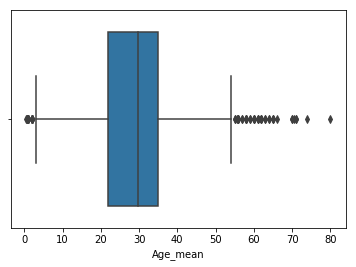

In [59]:
sns.boxplot(data_train.Age_mean)

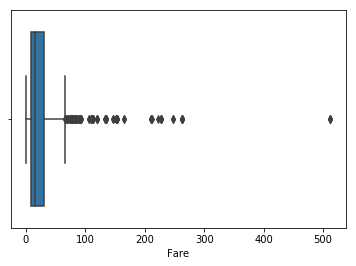

In [60]:
sns.boxplot(data_train.Fare)

- Fare and Age imputed with mean clearly have outlier. We will use IQR to bound both the variables

In [61]:
# calculate upper bound for Fair
IQR = data_train.Fare.quantile(0.75) - data_train.Fare.quantile(0.25)
upper_bound = data_train.Fare.quantile(0.75) + 3*IQR
# for train and test sets convert all values in column Fair where fare is more than upper_bound to upper_bound:
data_train.loc[data_train.Fare >upper_bound, 'Fare'] = upper_bound 
data_test.loc[data_test.Fare >upper_bound, 'Fare'] = upper_bound

In [62]:
# calculate bound for Age_mean
IQR = data_train.Age_mean.quantile(0.75) - data_train.Age_mean.quantile(0.25)
upper_bound = data_train.Age_mean.quantile(0.75) + 3*IQR
lower_bound = data_train.Age_mean.quantile(0.25) - 3*IQR
# for train and test sets convert all values in column Age_mean where Age_mean is more than upper_bound to upper_bound:
data_train.loc[data_train.Age_mean >upper_bound, 'Age_mean'] = upper_bound 
data_train.loc[data_train.Age_mean <lower_bound, 'Age_mean'] = lower_bound 

data_test.loc[data_test.Age_mean >upper_bound, 'Age_mean'] = upper_bound
data_test.loc[data_test.Age_mean <lower_bound, 'Age_mean'] = lower_bound 

In [63]:
# calculate bound for Age
IQR = data_train.Age.quantile(0.75) - data_train.Age.quantile(0.25)
upper_bound = data_train.Age.quantile(0.75) + 3*IQR
lower_bound = data_train.Age.quantile(0.25) - 3*IQR
# for train and test sets convert all values in column Age where Age is more than upper_bound to upper_bound:
data_train.loc[data_train.Age >upper_bound, 'Age'] = upper_bound 
data_train.loc[data_train.Age <lower_bound, 'Age'] = lower_bound 

data_test.loc[data_test.Age >upper_bound, 'Age'] = upper_bound
data_test.loc[data_test.Age <lower_bound, 'Age'] = lower_bound 

In [64]:
data_train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Age_NA', 'Age_mean', 'ticket_type', 'cabin_type', 'family',
       'title', 'family_size', 'family_size_grp', 'female_children'],
      dtype='object')

In [65]:
data_test.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'Age_NA', 'Age_mean', 'ticket_type', 'cabin_type', 'family', 'title',
       'family_size', 'family_size_grp'],
      dtype='object')

# 8. Feature Selection

In [66]:
# Dropping few Variables:
# Name - Now irrelevants as important parts are extracted
# SibSp and Parch - Both are combined to form Family Size Groups
# female_children - as Sex and age contains similar information

data_train_latest=data_train.drop(columns=["Name","SibSp","Parch","Age_NA","family","family_size","female_children"],axis=1)
data_test_latest=data_test.drop(columns=["Name","SibSp","Parch","Age_NA","family","family_size"],axis=1)


In [67]:
data_test_latest.shape

(418, 10)

In [68]:
data_train_latest.shape

(891, 11)

In [69]:
data_train_latest1=data_train_latest.drop(["Pclass"],axis=1)

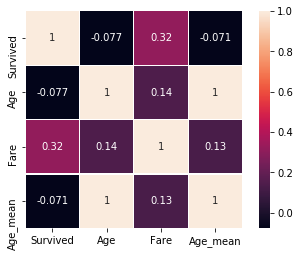

In [70]:
sns.heatmap(data_train_latest1.corr(),linewidths=0.1,vmax=1.0, 
            square=True,linecolor='white', annot=True)

#### Age and Age_mean are highly correlated so dropping Age

In [71]:
data_train_latest=data_train_latest.drop(["Age"],axis=1)
data_test_latest=data_test_latest.drop(["Age"],axis=1)

In [72]:
print("Columns in latest Train Data:",data_train_latest.shape)
print("Columns in latest Test Data:",data_test_latest.shape)

Columns in latest Train Data: (891, 10)
Columns in latest Test Data: (418, 9)


### Relationship between Survival Rate and below variables:
- 'Pclass'(Categorical)
- 'Sex' (Categorical)
- 'Embarked'(Categorical) 
- 'Fare'(Continuous)
- 'Age_mean'(Continuous)

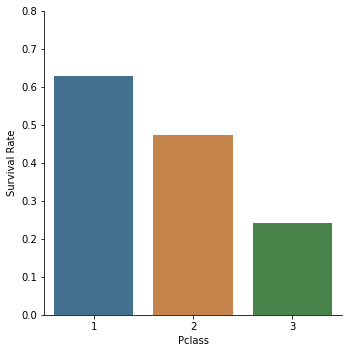

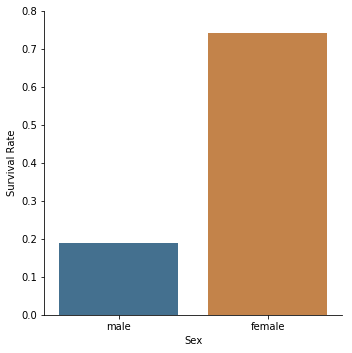

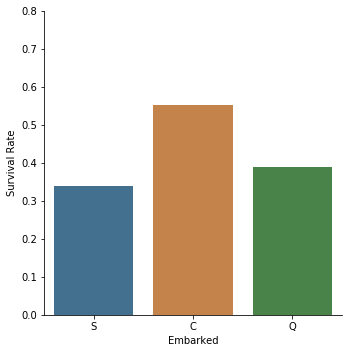

In [73]:
for col in ['Pclass','Sex','Embarked']:
    sns.catplot(x = col, y = 'Survived', data = data_train,saturation=0.5,kind="bar", ci=None)
    plt.ylim(0,0.8)
    plt.ylabel("Survival Rate")
    plt.show()

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 1800x720 with 0 Axes>

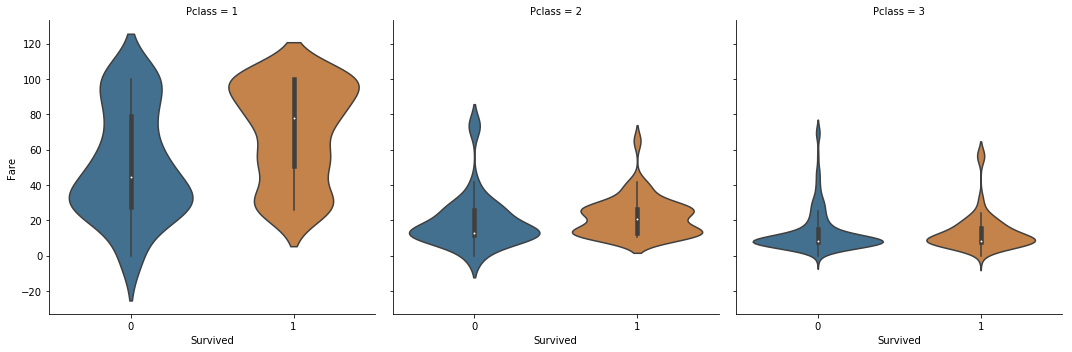

In [74]:
plt.figure(figsize=(25,10))
sns.catplot(x = 'Survived',y="Fare", data = data_train,saturation=0.5,kind="violin",col="Pclass", ci=None)
plt.show()

### Statistical to Determine which are important variables

- 'Survived'(Categorical) Target Variable
- 'Pclass'(Categorical) Chisq test
- 'Sex' (Categorical) Chisq test
- 'Embarked'(Categorical) Chisq test
- 'ticket_type'(Categorical) Chisq test
- 'cabin_type'(Categorical) Chisq test
- 'title'(Categorical) Chisq test
- 'family_size_grp'(Categorical) Chisq test
- 'Fare'(Continuous) Anova
- 'Age_mean'(Continuous) Anova

##### ticket_type, cabin_type, title, family_size_grp are tested above, and were found to be significant

### Passenger Class vs Survival Statistical Test

In [75]:
crosstab = pd.crosstab(data_train['Pclass'], data_train['Survived'])
crosstab

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [76]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")

if(p_val<0.05):
    print("There is a Significant Relationship")

===Chi2 Stat===
102.88898875696056


===Degrees of Freedom===
2


===P-Value===
4.549251711298793e-23


There is a Significant Relationship


Conclusion- There is a significant relationship between Passenger Class and having a better chance of survival

### Gender vs Survival Statistical Test

In [77]:
crosstab = pd.crosstab(data_train['Sex'], data_train['Survived'])
crosstab

Survived,0,1
Sex,,
female,81,233
male,468,109


In [78]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")

if(p_val<0.05):
    print("There is a Significant Relationship")

===Chi2 Stat===
260.71702016732104


===Degrees of Freedom===
1


===P-Value===
1.1973570627755645e-58


There is a Significant Relationship


Conclusion- There is a significant relationship between Gender and having a better chance of survival

### Embarked vs Survival Statistical Test

In [79]:
crosstab = pd.crosstab(data_train['Embarked'], data_train['Survived'])
crosstab

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,219


In [80]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")

if(p_val<0.05):
    print("There is a Significant Relationship")

===Chi2 Stat===
25.964452881874784


===Degrees of Freedom===
2


===P-Value===
2.3008626481449577e-06


There is a Significant Relationship


Conclusion- There is a significant relationship between Embarking Point and having a better chance of survival

### Fare vs Survival Statistical Test

In [81]:
f, p =stats.f_oneway(data_train[data_train["Survived"]==0].Fare,
               data_train[data_train["Survived"]==1].Fare)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(data_train['Fare'], data_train['Survived'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 100.08091139583851
P value: 2.122603840585235e-22 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    17.8725  14.3662 21.3788  True 
---------------------------------------------
[0 1]


Conclusion- There is a significant relationship between Fare and having a better chance of survival

### Age vs Survival Statistical Test

In [82]:
f, p =stats.f_oneway(data_train[data_train["Survived"]==0].Age_mean,
               data_train[data_train["Survived"]==1].Age_mean)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(data_train['Age_mean'], data_train['Survived'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 4.453088483482037
P value: 0.035117023057783116 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower   upper  reject
--------------------------------------------
  0      1    -1.8829  -3.634 -0.1317  True 
--------------------------------------------
[0 1]


Conclusion- There is a significant relationship between Age and having a better chance of survival

### Family Size vs Survival Statistical Test

In [83]:
f, p =stats.f_oneway(data_train[data_train["Survived"]==0].family_size,
               data_train[data_train["Survived"]==1].family_size)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(data_train['family_size'], data_train['Survived'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 0.24619311233984817
P value: 0.6198911221344969 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.0552  -0.1631 0.2734 False 
--------------------------------------------
[0 1]


Conclusion- The relationship between Family Size and having a better chance of survival is NOT Sigificant

### Variables selected for Modeling are:
- 'Survived'(Categorical) Target Variable
- 'Pclass'(Categorical)
- 'Sex' (Categorical)
- 'Embarked'(Categorical)
- 'ticket_type'(Categorical)
- 'cabin_type'(Categorical)
- 'title'(Categorical)
- 'family_size_grp'(Categorical)
- 'Fare'(Continuous)
- 'Age_mean'(Continuous)

# 9. Feature Encoding

In [84]:
print("New Train data's column:",data_train_latest.columns)
print("New Test data's column:",data_test_latest.columns)

New Train data's column: Index(['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'Age_mean',
       'ticket_type', 'cabin_type', 'title', 'family_size_grp'],
      dtype='object')
New Test data's column: Index(['Pclass', 'Sex', 'Fare', 'Embarked', 'Age_mean', 'ticket_type',
       'cabin_type', 'title', 'family_size_grp'],
      dtype='object')


In [85]:
data_train_latest1=data_train_latest
data_test_latest1=data_test_latest

In [86]:
columns = ['Pclass','Sex','Embarked', 'ticket_type','cabin_type', 'title','family_size_grp']

for col in columns:
    data_train_latest1 = pd.concat([data_train_latest1, pd.get_dummies(data_train_latest1[col], drop_first = True,prefix=col)], axis =1)
    data_test_latest1 = pd.concat([data_test_latest1, pd.get_dummies(data_test_latest1[col], drop_first = True,prefix=col)], axis =1)

data_train_latest1 = data_train_latest1.drop(columns, axis=1)
data_test_latest1 = data_test_latest1.drop(columns, axis=1)

In [87]:
data_train_latest1.head()

,Survived,Fare,Age_mean,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,ticket_type_CA,ticket_type_NO,...,cabin_type_D,cabin_type_E,cabin_type_NaN,cabin_type_OTHER,title_Miss,title_Mr,title_Mrs,title_OTHER,family_size_grp_Singleton,family_size_grp_Small Family
0,0,7.2500,22.0,0,1,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,1,71.2833,38.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,7.9250,26.0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
3,1,53.1000,35.0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0,8.0500,35.0,0,1,1,0,1,0,1,...,0,0,1,0,0,1,0,0,1,0


In [88]:
data_test_latest1.head()

,Fare,Age_mean,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,ticket_type_CA,ticket_type_NO,ticket_type_OTHER_T,...,cabin_type_D,cabin_type_E,cabin_type_NaN,cabin_type_OTHER,title_Miss,title_Mr,title_Mrs,title_OTHER,family_size_grp_Singleton,family_size_grp_Small Family
0,7.8292,34.5,0,1,1,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,7.0000,47.0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,1
2,9.6875,62.0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
3,8.6625,27.0,0,1,1,0,1,0,1,0,...,0,0,1,0,0,1,0,0,1,0
4,12.2875,22.0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,1


In [89]:
print("Encoded Train data's column:",data_train_latest1.columns)
print("Encoded Test data's column:",data_test_latest1.columns)

Encoded Train data's column: Index(['Survived', 'Fare', 'Age_mean', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S', 'ticket_type_CA', 'ticket_type_NO',
       'ticket_type_OTHER_T', 'ticket_type_PC', 'cabin_type_C', 'cabin_type_D',
       'cabin_type_E', 'cabin_type_NaN', 'cabin_type_OTHER', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_OTHER', 'family_size_grp_Singleton',
       'family_size_grp_Small Family'],
      dtype='object')
Encoded Test data's column: Index(['Fare', 'Age_mean', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'ticket_type_CA', 'ticket_type_NO', 'ticket_type_OTHER_T',
       'ticket_type_PC', 'cabin_type_C', 'cabin_type_D', 'cabin_type_E',
       'cabin_type_NaN', 'cabin_type_OTHER', 'title_Miss', 'title_Mr',
       'title_Mrs', 'title_OTHER', 'family_size_grp_Singleton',
       'family_size_grp_Small Family'],
      dtype='object')


In [90]:
data_test_latest1["Fare"]=data_test_latest1["Fare"].fillna(data_test_latest1["Fare"].median())

 # 10. Split the Dataset

In [91]:
X=data_train_latest1[['Fare','Age_mean', 'Pclass_2', 'Pclass_3', 'Sex_male',
       'Embarked_Q', 'Embarked_S', 'ticket_type_CA', 'ticket_type_NO',
       'ticket_type_OTHER_T', 'ticket_type_PC', 'cabin_type_C', 'cabin_type_D',
       'cabin_type_E', 'cabin_type_NaN', 'cabin_type_OTHER', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_OTHER', 'family_size_grp_Singleton',
       'family_size_grp_Small Family']]
y=data_train_latest1['Survived']

In [92]:
# splitting the data into training and test sets (80:20)
from sklearn.model_selection import train_test_split
X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=0.2,random_state=4)

In [93]:
print(X.shape)
print(y.shape)

(891, 22)
(891,)


# 11. Train the Model

# 11.1 Logistic Regression

In [94]:
### Import functions for Model Evaluation 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression

In [95]:
## Train the Logistic Regression Model and Predcit for test data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_validation)
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(confusion_matrix(y_validation, y_pred))
print(classification_report(y_validation, y_pred))
print(accuracy_score(y_validation, y_pred))

[[108  11]
 [ 16  44]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       119
           1       0.80      0.73      0.77        60

    accuracy                           0.85       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.85      0.85      0.85       179

0.8491620111731844


C:\Users\abhay\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


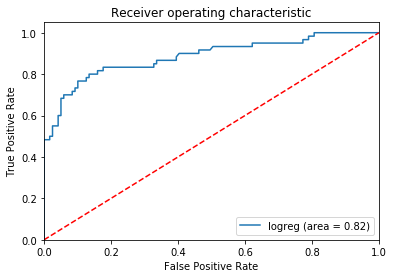

In [96]:
##########Generating AUC plot and ROC curve#############
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logreg_roc_auc = roc_auc_score(y_validation, logreg.predict(X_validation))
fpr, tpr, thresholds = roc_curve(y_validation, logreg.predict_proba(X_validation)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='logreg (area = %0.2f)' % logreg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [97]:
data_test_latest1["Survived"]=logreg.predict(data_test_latest1)

In [98]:
data_test_latest1.to_csv("Submission1.csv")

# 11.1 Decision Tree

In [767]:
#from sklearn.externals.six import StringIO  
#from IPython.display import Image  
#from sklearn.tree import export_graphviz
#import pydotplus

Model accuracy :  0.8324022346368715
[[107  12]
 [ 18  42]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       119
           1       0.78      0.70      0.74        60

    accuracy                           0.83       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.83      0.83      0.83       179

0.8324022346368715


[Text(422,719.6,'Sex_male <= 0.5\ngini = 0.478\nsamples = 712\nvalue = [430, 282]\nclass = Survived NO'),
 Text(211,514,'Pclass_3 <= 0.5\ngini = 0.384\nsamples = 262\nvalue = [68, 194]\nclass = Survived Yes'),
 Text(105.5,308.4,'Age_mean <= 2.5\ngini = 0.12\nsamples = 140\nvalue = [9, 131]\nclass = Survived Yes'),
 Text(52.75,102.8,'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Survived NO'),
 Text(158.25,102.8,'gini = 0.108\nsamples = 139\nvalue = [8, 131]\nclass = Survived Yes'),
 Text(316.5,308.4,'Fare <= 23.35\ngini = 0.499\nsamples = 122\nvalue = [59, 63]\nclass = Survived Yes'),
 Text(263.75,102.8,'gini = 0.48\nsamples = 100\nvalue = [40, 60]\nclass = Survived Yes'),
 Text(369.25,102.8,'gini = 0.236\nsamples = 22\nvalue = [19, 3]\nclass = Survived NO'),
 Text(633,514,'cabin_type_NaN <= 0.5\ngini = 0.315\nsamples = 450\nvalue = [362, 88]\nclass = Survived NO'),
 Text(527.5,308.4,'Age_mean <= 14.5\ngini = 0.487\nsamples = 88\nvalue = [51, 37]\nclass = Survived NO'),
 Text(474.75

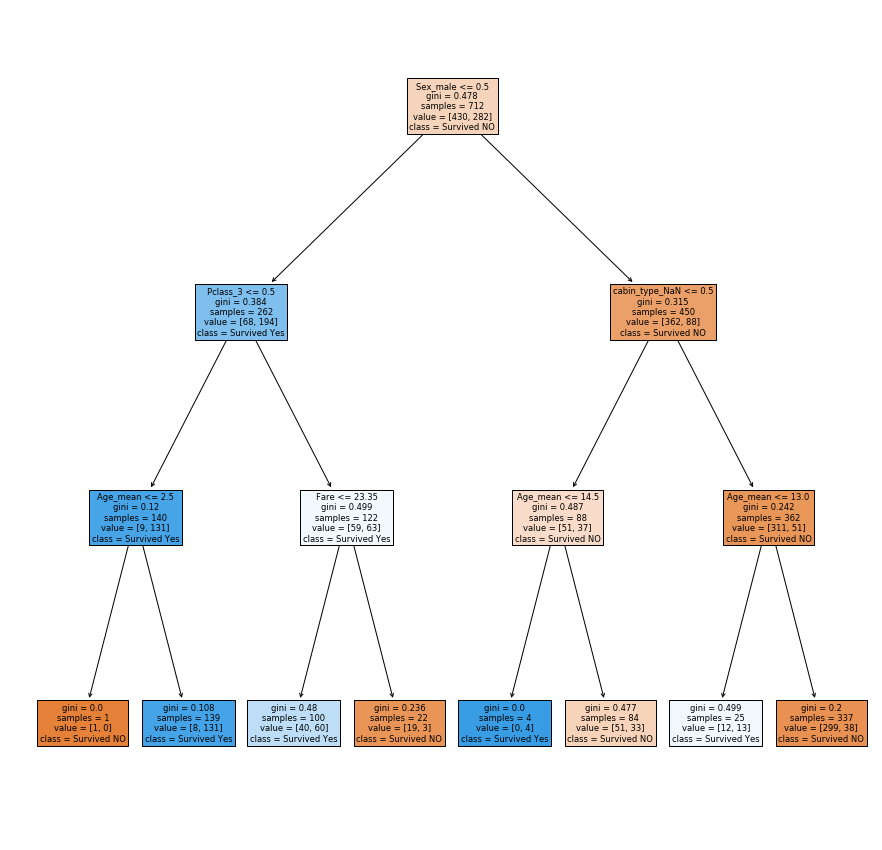

In [99]:
plt.figure(figsize=[15,15])
clf_dt = tree.DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

y_pred = clf_dt.predict(X_validation)
score = accuracy_score(y_validation,y_pred)

print('Model accuracy : ', score)
# setting performance parameters
print(confusion_matrix(y_validation,y_pred))  
print(classification_report(y_validation,y_pred))  
print(accuracy_score(y_validation, y_pred)) 
##dot_data = StringIO()
#tree.export_graphviz(clf_dt, out_file=dot_data,filled=True, rounded=True,special_characters=True, feature_names = X.columns,class_names=['Survived NO','Survived Yes'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())
plot_tree(clf_dt, filled=True,feature_names=X.columns,class_names=['Survived NO','Survived Yes'])

# 11.2 Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)
# Use the forest's predict method on the test data
y_pred = model.predict(X_validation)
print(confusion_matrix(y_validation, y_pred))
print(classification_report(y_validation, y_pred))
print(accuracy_score(y_validation, y_pred))


[[111   8]
 [ 17  43]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       119
           1       0.84      0.72      0.77        60

    accuracy                           0.86       179
   macro avg       0.86      0.82      0.84       179
weighted avg       0.86      0.86      0.86       179

0.8603351955307262


# 11.3 CatBoost

In [813]:
data_train_latest.columns

Index(['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'Age_mean',
       'ticket_type', 'cabin_type', 'title', 'family_size_grp'],
      dtype='object')

In [814]:
X=data_train_latest[['Pclass', 'Sex', 'Fare', 'Embarked', 'Age_mean',
       'ticket_type', 'cabin_type', 'title', 'family_size_grp']]
y=data_train_latest['Survived']

In [815]:
# splitting the data into training and test sets (80:20)
from sklearn.model_selection import train_test_split
X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=0.2,random_state=5)

In [816]:
X_train.dtypes

Pclass               int64
Sex                 object
Fare               float64
Embarked            object
Age_mean           float64
ticket_type         object
cabin_type          object
title               object
family_size_grp     object
dtype: object

In [817]:
categorical_features_indices = [0, 1, 3, 5, 6, 7, 8]

In [821]:
from catboost import CatBoostClassifier

In [861]:
model=CatBoostClassifier(iterations=200, depth=8, learning_rate=0.015,loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True,verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6874970	test: 0.6873290	best: 0.6873290 (0)	total: 16.4ms	remaining: 3.27s
1:	learn: 0.6782435	test: 0.6777948	best: 0.6777948 (1)	total: 73.2ms	remaining: 7.25s
2:	learn: 0.6683676	test: 0.6674073	best: 0.6674073 (2)	total: 110ms	remaining: 7.21s
3:	learn: 0.6594063	test: 0.6582281	best: 0.6582281 (3)	total: 194ms	remaining: 9.5s
4:	learn: 0.6513039	test: 0.6494973	best: 0.6494973 (4)	total: 228ms	remaining: 8.88s
5:	learn: 0.6428798	test: 0.6408417	best: 0.6408417 (5)	total: 283ms	remaining: 9.15s
6:	learn: 0.6372611	test: 0.6349495	best: 0.6349495 (6)	total: 314ms	remaining: 8.67s
7:	learn: 0.6288348	test: 0.6269079	best: 0.6269079 (7)	total: 372ms	remaining: 8.93s
8:	learn: 0.6206795	test: 0.6187687	best: 0.6187687 (8)	total: 431ms	remaining: 9.15s
9:	learn: 0.6139077	test: 0.6120686	best: 0.6120686 (9)	total: 466ms	remaining: 8.86s
10:	learn: 0.6100346	test: 0.6081330	best: 0.6081330 (10)	total: 480ms	remaining: 8.25s
11:	learn: 0.6062880	test: 0.6043262	best: 0.604326

95:	learn: 0.3848673	test: 0.4027337	best: 0.4027337 (95)	total: 5.73s	remaining: 6.21s
96:	learn: 0.3829518	test: 0.4029589	best: 0.4027337 (95)	total: 5.8s	remaining: 6.16s
97:	learn: 0.3821821	test: 0.4024768	best: 0.4024768 (97)	total: 5.86s	remaining: 6.1s
98:	learn: 0.3810245	test: 0.4015519	best: 0.4015519 (98)	total: 5.92s	remaining: 6.04s
99:	learn: 0.3799257	test: 0.4004619	best: 0.4004619 (99)	total: 5.99s	remaining: 5.99s
100:	learn: 0.3789179	test: 0.3997743	best: 0.3997743 (100)	total: 6.07s	remaining: 5.95s
101:	learn: 0.3774663	test: 0.3991895	best: 0.3991895 (101)	total: 6.13s	remaining: 5.89s
102:	learn: 0.3771196	test: 0.3990916	best: 0.3990916 (102)	total: 6.16s	remaining: 5.8s
103:	learn: 0.3760776	test: 0.3985717	best: 0.3985717 (103)	total: 6.23s	remaining: 5.75s
104:	learn: 0.3753736	test: 0.3979110	best: 0.3979110 (104)	total: 6.3s	remaining: 5.7s
105:	learn: 0.3743265	test: 0.3977464	best: 0.3977464 (105)	total: 6.35s	remaining: 5.63s
106:	learn: 0.3731737	tes

189:	learn: 0.3261117	test: 0.3841816	best: 0.3839749 (178)	total: 11.8s	remaining: 621ms
190:	learn: 0.3256150	test: 0.3841080	best: 0.3839749 (178)	total: 11.9s	remaining: 559ms
191:	learn: 0.3247550	test: 0.3838914	best: 0.3838914 (191)	total: 11.9s	remaining: 497ms
192:	learn: 0.3243716	test: 0.3839676	best: 0.3838914 (191)	total: 12s	remaining: 435ms
193:	learn: 0.3241864	test: 0.3839383	best: 0.3838914 (191)	total: 12.1s	remaining: 373ms
194:	learn: 0.3233569	test: 0.3839600	best: 0.3838914 (191)	total: 12.1s	remaining: 311ms
195:	learn: 0.3227986	test: 0.3835833	best: 0.3835833 (195)	total: 12.2s	remaining: 249ms
196:	learn: 0.3219852	test: 0.3836320	best: 0.3835833 (195)	total: 12.3s	remaining: 187ms
197:	learn: 0.3216545	test: 0.3834262	best: 0.3834262 (197)	total: 12.4s	remaining: 125ms
198:	learn: 0.3216439	test: 0.3834344	best: 0.3834262 (197)	total: 12.4s	remaining: 62.2ms
199:	learn: 0.3209330	test: 0.3832606	best: 0.3832606 (199)	total: 12.4s	remaining: 0us

bestTest = 0

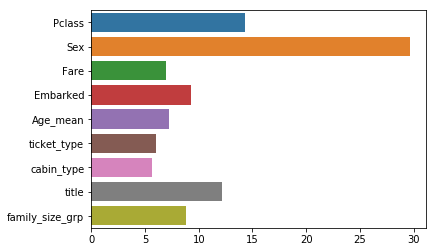

In [862]:
features=model.feature_names_
sns.barplot(model.feature_importances_, features)
plt.show()

In [863]:
# Use the catboost's predict method on the test data
y_pred = model.predict(X_validation)
print(confusion_matrix(y_validation, y_pred))
print(classification_report(y_validation, y_pred))
print(accuracy_score(y_validation, y_pred))

[[102   9]
 [ 19  49]]
             precision    recall  f1-score   support

          0       0.84      0.92      0.88       111
          1       0.84      0.72      0.78        68

avg / total       0.84      0.84      0.84       179

0.8435754189944135


In [864]:
data_test_latest["Survived"]=model.predict(data_test_latest)

In [865]:
data_test_latest.to_csv("Submission6.csv")

# 11.4 LightGBM

In [872]:
from lightgbm import LGBMClassifier
from sklearn import preprocessing

In [880]:
# Label encode categorical columns for use in LightGBM.
label_encode_columns = ['Pclass', 
                        'Sex',   
                        'Embarked', 
                        'ticket_type', 
                        'cabin_type',
                        'title',
                        'family_size_grp']
le = preprocessing.LabelEncoder()

for col in label_encode_columns:
    le.fit(data_train_latest[col])
    data_train_latest[col + '_encoded'] = le.transform(data_train_latest[col])
    data_test_latest[col + '_encoded'] = le.transform(data_test_latest[col])

In [881]:
# Prepare a list of columns to train on.
# Also decide which features to treat as numeric and which features to treat
# as categorical.
columns_to_train = ['Pclass_encoded', 'Sex_encoded', 'Fare', 'Embarked_encoded', 'Age_mean', 'ticket_type_encoded', 'cabin_type_encoded', 'title_encoded', 'family_size_grp_encoded']

categorical_columns = ['Pclass_encoded', 'Sex_encoded', 'Embarked_encoded','ticket_type_encoded', 'cabin_type_encoded', 'title_encoded', 'family_size_grp_encoded']

numerical_columns = [col for col in columns_to_train if col not in categorical_columns]


In [882]:
# splitting the data into training and test sets (80:20)
from sklearn.model_selection import train_test_split
X=data_train_latest[['Pclass_encoded', 'Sex_encoded', 'Fare', 'Embarked_encoded', 'Age_mean', 'ticket_type_encoded', 'cabin_type_encoded', 'title_encoded', 'family_size_grp_encoded']]
y=data_train_latest["Survived"]
X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=0.2,random_state=5)

In [883]:
X_train.columns

Index(['Pclass_encoded', 'Sex_encoded', 'Fare', 'Embarked_encoded', 'Age_mean',
       'ticket_type_encoded', 'cabin_type_encoded', 'title_encoded',
       'family_size_grp_encoded'],
      dtype='object')

In [890]:
# Train the LightGBM model on the best parameters obtained by grid search.
g = {'colsample_bytree': 0.4,
     'min_child_samples': 5,
     'num_leaves': 255}

estimator = LGBMClassifier(learning_rate=0.02,
                          n_estimators=10000,
                          silent=False,
                          **g)

fit_params = {'early_stopping_rounds': 4000,
              'feature_name': categorical_columns + numerical_columns,
              'categorical_feature': categorical_columns,
              'eval_set': [(X_train, y_train), (X_validation, y_validation)]}

estimator.fit(X_train, y_train, **fit_params)

C:\Users\abhay\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked_encoded', 'Pclass_encoded', 'Sex_encoded', 'cabin_type_encoded', 'family_size_grp_encoded', 'ticket_type_encoded', 'title_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\abhay\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Embarked_encoded', 'Pclass_encoded', 'Sex_encoded', 'cabin_type_encoded', 'family_size_grp_encoded', 'ticket_type_encoded', 'title_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's binary_logloss: 0.658655	valid_1's binary_logloss: 0.656011
Training until validation scores don't improve for 4000 rounds.
[2]	training's binary_logloss: 0.652199	valid_1's binary_logloss: 0.649945
[3]	training's binary_logloss: 0.650149	valid_1's binary_logloss: 0.647553
[4]	training's binary_logloss: 0.647556	valid_1's binary_logloss: 0.644318
[5]	training's binary_logloss: 0.644796	valid_1's binary_logloss: 0.641173
[6]	training's binary_logloss: 0.637411	valid_1's binary_logloss: 0.633426
[7]	training's binary_logloss: 0.636099	valid_1's binary_logloss: 0.63188
[8]	training's binary_logloss: 0.631083	valid_1's binary_logloss: 0.626866
[9]	training's binary_logloss: 0.625448	valid_1's binary_logloss: 0.620867
[10]	training's binary_logloss: 0.620833	valid_1's binary_logloss: 0.61625
[11]	training's binary_logloss: 0.616003	valid_1's binary_logloss: 0.611434
[12]	training's binary_logloss: 0.609707	valid_1's binary_logloss: 0.605198
[13]	training's binary_logloss: 0.6

[190]	training's binary_logloss: 0.39925	valid_1's binary_logloss: 0.399848
[191]	training's binary_logloss: 0.398564	valid_1's binary_logloss: 0.399824
[192]	training's binary_logloss: 0.397987	valid_1's binary_logloss: 0.399557
[193]	training's binary_logloss: 0.39694	valid_1's binary_logloss: 0.398747
[194]	training's binary_logloss: 0.396593	valid_1's binary_logloss: 0.398567
[195]	training's binary_logloss: 0.396008	valid_1's binary_logloss: 0.398002
[196]	training's binary_logloss: 0.395443	valid_1's binary_logloss: 0.397457
[197]	training's binary_logloss: 0.394875	valid_1's binary_logloss: 0.396797
[198]	training's binary_logloss: 0.394495	valid_1's binary_logloss: 0.396825
[199]	training's binary_logloss: 0.393467	valid_1's binary_logloss: 0.396354
[200]	training's binary_logloss: 0.392819	valid_1's binary_logloss: 0.395886
[201]	training's binary_logloss: 0.392496	valid_1's binary_logloss: 0.395899
[202]	training's binary_logloss: 0.392175	valid_1's binary_logloss: 0.395911
[

[300]	training's binary_logloss: 0.363184	valid_1's binary_logloss: 0.384957
[301]	training's binary_logloss: 0.362994	valid_1's binary_logloss: 0.384922
[302]	training's binary_logloss: 0.362917	valid_1's binary_logloss: 0.384857
[303]	training's binary_logloss: 0.362807	valid_1's binary_logloss: 0.385048
[304]	training's binary_logloss: 0.362658	valid_1's binary_logloss: 0.38493
[305]	training's binary_logloss: 0.362539	valid_1's binary_logloss: 0.385044
[306]	training's binary_logloss: 0.362229	valid_1's binary_logloss: 0.384868
[307]	training's binary_logloss: 0.361578	valid_1's binary_logloss: 0.384534
[308]	training's binary_logloss: 0.361476	valid_1's binary_logloss: 0.384374
[309]	training's binary_logloss: 0.3613	valid_1's binary_logloss: 0.384449
[310]	training's binary_logloss: 0.361168	valid_1's binary_logloss: 0.384483
[311]	training's binary_logloss: 0.360822	valid_1's binary_logloss: 0.38444
[312]	training's binary_logloss: 0.360696	valid_1's binary_logloss: 0.384274
[31

[509]	training's binary_logloss: 0.326804	valid_1's binary_logloss: 0.385469
[510]	training's binary_logloss: 0.326555	valid_1's binary_logloss: 0.385462
[511]	training's binary_logloss: 0.326525	valid_1's binary_logloss: 0.385415
[512]	training's binary_logloss: 0.326362	valid_1's binary_logloss: 0.38547
[513]	training's binary_logloss: 0.326354	valid_1's binary_logloss: 0.385463
[514]	training's binary_logloss: 0.326247	valid_1's binary_logloss: 0.385404
[515]	training's binary_logloss: 0.326067	valid_1's binary_logloss: 0.385422
[516]	training's binary_logloss: 0.325958	valid_1's binary_logloss: 0.385443
[517]	training's binary_logloss: 0.325716	valid_1's binary_logloss: 0.385519
[518]	training's binary_logloss: 0.325433	valid_1's binary_logloss: 0.385338
[519]	training's binary_logloss: 0.325387	valid_1's binary_logloss: 0.385333
[520]	training's binary_logloss: 0.325253	valid_1's binary_logloss: 0.385295
[521]	training's binary_logloss: 0.325228	valid_1's binary_logloss: 0.385376


[628]	training's binary_logloss: 0.314665	valid_1's binary_logloss: 0.388278
[629]	training's binary_logloss: 0.314591	valid_1's binary_logloss: 0.388266
[630]	training's binary_logloss: 0.314516	valid_1's binary_logloss: 0.388105
[631]	training's binary_logloss: 0.314481	valid_1's binary_logloss: 0.388144
[632]	training's binary_logloss: 0.314341	valid_1's binary_logloss: 0.388351
[633]	training's binary_logloss: 0.314136	valid_1's binary_logloss: 0.388446
[634]	training's binary_logloss: 0.314103	valid_1's binary_logloss: 0.388412
[635]	training's binary_logloss: 0.314088	valid_1's binary_logloss: 0.388474
[636]	training's binary_logloss: 0.313944	valid_1's binary_logloss: 0.388596
[637]	training's binary_logloss: 0.313751	valid_1's binary_logloss: 0.388606
[638]	training's binary_logloss: 0.313613	valid_1's binary_logloss: 0.388666
[639]	training's binary_logloss: 0.313599	valid_1's binary_logloss: 0.388668
[640]	training's binary_logloss: 0.313537	valid_1's binary_logloss: 0.388664

[741]	training's binary_logloss: 0.30469	valid_1's binary_logloss: 0.393825
[742]	training's binary_logloss: 0.304602	valid_1's binary_logloss: 0.393964
[743]	training's binary_logloss: 0.304558	valid_1's binary_logloss: 0.393997
[744]	training's binary_logloss: 0.304517	valid_1's binary_logloss: 0.39404
[745]	training's binary_logloss: 0.304351	valid_1's binary_logloss: 0.394244
[746]	training's binary_logloss: 0.304306	valid_1's binary_logloss: 0.394258
[747]	training's binary_logloss: 0.304252	valid_1's binary_logloss: 0.394299
[748]	training's binary_logloss: 0.304241	valid_1's binary_logloss: 0.394348
[749]	training's binary_logloss: 0.304239	valid_1's binary_logloss: 0.394326
[750]	training's binary_logloss: 0.304199	valid_1's binary_logloss: 0.394405
[751]	training's binary_logloss: 0.304122	valid_1's binary_logloss: 0.394459
[752]	training's binary_logloss: 0.304046	valid_1's binary_logloss: 0.394529
[753]	training's binary_logloss: 0.304042	valid_1's binary_logloss: 0.394509
[

[852]	training's binary_logloss: 0.29803	valid_1's binary_logloss: 0.400246
[853]	training's binary_logloss: 0.298024	valid_1's binary_logloss: 0.400184
[854]	training's binary_logloss: 0.297997	valid_1's binary_logloss: 0.400247
[855]	training's binary_logloss: 0.297882	valid_1's binary_logloss: 0.400475
[856]	training's binary_logloss: 0.29783	valid_1's binary_logloss: 0.400529
[857]	training's binary_logloss: 0.297821	valid_1's binary_logloss: 0.400562
[858]	training's binary_logloss: 0.297768	valid_1's binary_logloss: 0.400619
[859]	training's binary_logloss: 0.297586	valid_1's binary_logloss: 0.400586
[860]	training's binary_logloss: 0.297583	valid_1's binary_logloss: 0.400568
[861]	training's binary_logloss: 0.297456	valid_1's binary_logloss: 0.400303
[862]	training's binary_logloss: 0.297425	valid_1's binary_logloss: 0.400467
[863]	training's binary_logloss: 0.297336	valid_1's binary_logloss: 0.400699
[864]	training's binary_logloss: 0.297291	valid_1's binary_logloss: 0.400667
[

[1068]	training's binary_logloss: 0.288149	valid_1's binary_logloss: 0.409825
[1069]	training's binary_logloss: 0.288148	valid_1's binary_logloss: 0.409821
[1070]	training's binary_logloss: 0.288146	valid_1's binary_logloss: 0.409812
[1071]	training's binary_logloss: 0.288042	valid_1's binary_logloss: 0.409769
[1072]	training's binary_logloss: 0.288022	valid_1's binary_logloss: 0.409914
[1073]	training's binary_logloss: 0.28802	valid_1's binary_logloss: 0.409883
[1074]	training's binary_logloss: 0.288012	valid_1's binary_logloss: 0.409865
[1075]	training's binary_logloss: 0.288007	valid_1's binary_logloss: 0.409849
[1076]	training's binary_logloss: 0.288005	valid_1's binary_logloss: 0.409834
[1077]	training's binary_logloss: 0.287987	valid_1's binary_logloss: 0.410017
[1078]	training's binary_logloss: 0.287973	valid_1's binary_logloss: 0.410075
[1079]	training's binary_logloss: 0.287956	valid_1's binary_logloss: 0.410259
[1080]	training's binary_logloss: 0.287954	valid_1's binary_loglo

[1294]	training's binary_logloss: 0.281306	valid_1's binary_logloss: 0.41658
[1295]	training's binary_logloss: 0.281301	valid_1's binary_logloss: 0.416693
[1296]	training's binary_logloss: 0.281257	valid_1's binary_logloss: 0.416581
[1297]	training's binary_logloss: 0.281248	valid_1's binary_logloss: 0.416592
[1298]	training's binary_logloss: 0.281247	valid_1's binary_logloss: 0.416571
[1299]	training's binary_logloss: 0.281246	valid_1's binary_logloss: 0.416568
[1300]	training's binary_logloss: 0.281203	valid_1's binary_logloss: 0.416702
[1301]	training's binary_logloss: 0.281203	valid_1's binary_logloss: 0.416703
[1302]	training's binary_logloss: 0.281133	valid_1's binary_logloss: 0.416803
[1303]	training's binary_logloss: 0.281063	valid_1's binary_logloss: 0.416994
[1304]	training's binary_logloss: 0.280988	valid_1's binary_logloss: 0.416986
[1305]	training's binary_logloss: 0.280979	valid_1's binary_logloss: 0.4171
[1306]	training's binary_logloss: 0.280969	valid_1's binary_logloss

[1411]	training's binary_logloss: 0.277465	valid_1's binary_logloss: 0.422101
[1412]	training's binary_logloss: 0.277465	valid_1's binary_logloss: 0.4221
[1413]	training's binary_logloss: 0.277457	valid_1's binary_logloss: 0.422216
[1414]	training's binary_logloss: 0.277411	valid_1's binary_logloss: 0.422254
[1415]	training's binary_logloss: 0.277411	valid_1's binary_logloss: 0.422252
[1416]	training's binary_logloss: 0.277396	valid_1's binary_logloss: 0.422449
[1417]	training's binary_logloss: 0.277389	valid_1's binary_logloss: 0.422547
[1418]	training's binary_logloss: 0.27738	valid_1's binary_logloss: 0.422579
[1419]	training's binary_logloss: 0.277339	valid_1's binary_logloss: 0.42252
[1420]	training's binary_logloss: 0.277338	valid_1's binary_logloss: 0.422521
[1421]	training's binary_logloss: 0.277322	valid_1's binary_logloss: 0.422616
[1422]	training's binary_logloss: 0.277318	valid_1's binary_logloss: 0.42273
[1423]	training's binary_logloss: 0.277317	valid_1's binary_logloss: 

[1528]	training's binary_logloss: 0.273381	valid_1's binary_logloss: 0.427017
[1529]	training's binary_logloss: 0.273367	valid_1's binary_logloss: 0.427051
[1530]	training's binary_logloss: 0.273295	valid_1's binary_logloss: 0.4272
[1531]	training's binary_logloss: 0.273294	valid_1's binary_logloss: 0.427171
[1532]	training's binary_logloss: 0.273288	valid_1's binary_logloss: 0.427285
[1533]	training's binary_logloss: 0.273267	valid_1's binary_logloss: 0.427455
[1534]	training's binary_logloss: 0.273265	valid_1's binary_logloss: 0.427434
[1535]	training's binary_logloss: 0.273231	valid_1's binary_logloss: 0.4275
[1536]	training's binary_logloss: 0.273216	valid_1's binary_logloss: 0.427695
[1537]	training's binary_logloss: 0.273209	valid_1's binary_logloss: 0.427889
[1538]	training's binary_logloss: 0.273177	valid_1's binary_logloss: 0.427964
[1539]	training's binary_logloss: 0.273177	valid_1's binary_logloss: 0.427963
[1540]	training's binary_logloss: 0.273177	valid_1's binary_logloss:

[1647]	training's binary_logloss: 0.269524	valid_1's binary_logloss: 0.433324
[1648]	training's binary_logloss: 0.269508	valid_1's binary_logloss: 0.433213
[1649]	training's binary_logloss: 0.269431	valid_1's binary_logloss: 0.43308
[1650]	training's binary_logloss: 0.269428	valid_1's binary_logloss: 0.433053
[1651]	training's binary_logloss: 0.26939	valid_1's binary_logloss: 0.433068
[1652]	training's binary_logloss: 0.269383	valid_1's binary_logloss: 0.433112
[1653]	training's binary_logloss: 0.269382	valid_1's binary_logloss: 0.433112
[1654]	training's binary_logloss: 0.269147	valid_1's binary_logloss: 0.433211
[1655]	training's binary_logloss: 0.269053	valid_1's binary_logloss: 0.433308
[1656]	training's binary_logloss: 0.269048	valid_1's binary_logloss: 0.433412
[1657]	training's binary_logloss: 0.268954	valid_1's binary_logloss: 0.433364
[1658]	training's binary_logloss: 0.268921	valid_1's binary_logloss: 0.43353
[1659]	training's binary_logloss: 0.268919	valid_1's binary_logloss

[1767]	training's binary_logloss: 0.265938	valid_1's binary_logloss: 0.43884
[1768]	training's binary_logloss: 0.265938	valid_1's binary_logloss: 0.438839
[1769]	training's binary_logloss: 0.265888	valid_1's binary_logloss: 0.438907
[1770]	training's binary_logloss: 0.265867	valid_1's binary_logloss: 0.438925
[1771]	training's binary_logloss: 0.265817	valid_1's binary_logloss: 0.438956
[1772]	training's binary_logloss: 0.265812	valid_1's binary_logloss: 0.439148
[1773]	training's binary_logloss: 0.265699	valid_1's binary_logloss: 0.439148
[1774]	training's binary_logloss: 0.265642	valid_1's binary_logloss: 0.439261
[1775]	training's binary_logloss: 0.265625	valid_1's binary_logloss: 0.439366
[1776]	training's binary_logloss: 0.265624	valid_1's binary_logloss: 0.439358
[1777]	training's binary_logloss: 0.26559	valid_1's binary_logloss: 0.439399
[1778]	training's binary_logloss: 0.265583	valid_1's binary_logloss: 0.439419
[1779]	training's binary_logloss: 0.265583	valid_1's binary_loglos

[1965]	training's binary_logloss: 0.261217	valid_1's binary_logloss: 0.447034
[1966]	training's binary_logloss: 0.26116	valid_1's binary_logloss: 0.446936
[1967]	training's binary_logloss: 0.261155	valid_1's binary_logloss: 0.446912
[1968]	training's binary_logloss: 0.261149	valid_1's binary_logloss: 0.446907
[1969]	training's binary_logloss: 0.261133	valid_1's binary_logloss: 0.446958
[1970]	training's binary_logloss: 0.261124	valid_1's binary_logloss: 0.446981
[1971]	training's binary_logloss: 0.261116	valid_1's binary_logloss: 0.446971
[1972]	training's binary_logloss: 0.261023	valid_1's binary_logloss: 0.447047
[1973]	training's binary_logloss: 0.261022	valid_1's binary_logloss: 0.447043
[1974]	training's binary_logloss: 0.261002	valid_1's binary_logloss: 0.446984
[1975]	training's binary_logloss: 0.260873	valid_1's binary_logloss: 0.447473
[1976]	training's binary_logloss: 0.260813	valid_1's binary_logloss: 0.44761
[1977]	training's binary_logloss: 0.26081	valid_1's binary_logloss

[2222]	training's binary_logloss: 0.255362	valid_1's binary_logloss: 0.453329
[2223]	training's binary_logloss: 0.255362	valid_1's binary_logloss: 0.45333
[2224]	training's binary_logloss: 0.255357	valid_1's binary_logloss: 0.453382
[2225]	training's binary_logloss: 0.255331	valid_1's binary_logloss: 0.453368
[2226]	training's binary_logloss: 0.255314	valid_1's binary_logloss: 0.453445
[2227]	training's binary_logloss: 0.255314	valid_1's binary_logloss: 0.453416
[2228]	training's binary_logloss: 0.255311	valid_1's binary_logloss: 0.453433
[2229]	training's binary_logloss: 0.25531	valid_1's binary_logloss: 0.453403
[2230]	training's binary_logloss: 0.255306	valid_1's binary_logloss: 0.453431
[2231]	training's binary_logloss: 0.255291	valid_1's binary_logloss: 0.453441
[2232]	training's binary_logloss: 0.255286	valid_1's binary_logloss: 0.453431
[2233]	training's binary_logloss: 0.255285	valid_1's binary_logloss: 0.453432
[2234]	training's binary_logloss: 0.255206	valid_1's binary_loglos

[2339]	training's binary_logloss: 0.252749	valid_1's binary_logloss: 0.45761
[2340]	training's binary_logloss: 0.252746	valid_1's binary_logloss: 0.4578
[2341]	training's binary_logloss: 0.252746	valid_1's binary_logloss: 0.457801
[2342]	training's binary_logloss: 0.252699	valid_1's binary_logloss: 0.457849
[2343]	training's binary_logloss: 0.252698	valid_1's binary_logloss: 0.457867
[2344]	training's binary_logloss: 0.252617	valid_1's binary_logloss: 0.4578
[2345]	training's binary_logloss: 0.252555	valid_1's binary_logloss: 0.457954
[2346]	training's binary_logloss: 0.252555	valid_1's binary_logloss: 0.457953
[2347]	training's binary_logloss: 0.252551	valid_1's binary_logloss: 0.457908
[2348]	training's binary_logloss: 0.252551	valid_1's binary_logloss: 0.457905
[2349]	training's binary_logloss: 0.252525	valid_1's binary_logloss: 0.457975
[2350]	training's binary_logloss: 0.252517	valid_1's binary_logloss: 0.457995
[2351]	training's binary_logloss: 0.252391	valid_1's binary_logloss: 

[2562]	training's binary_logloss: 0.247787	valid_1's binary_logloss: 0.466866
[2563]	training's binary_logloss: 0.247776	valid_1's binary_logloss: 0.466849
[2564]	training's binary_logloss: 0.247766	valid_1's binary_logloss: 0.466825
[2565]	training's binary_logloss: 0.247755	valid_1's binary_logloss: 0.466827
[2566]	training's binary_logloss: 0.247737	valid_1's binary_logloss: 0.466849
[2567]	training's binary_logloss: 0.247714	valid_1's binary_logloss: 0.466908
[2568]	training's binary_logloss: 0.247695	valid_1's binary_logloss: 0.466896
[2569]	training's binary_logloss: 0.247686	valid_1's binary_logloss: 0.466958
[2570]	training's binary_logloss: 0.24768	valid_1's binary_logloss: 0.466967
[2571]	training's binary_logloss: 0.247679	valid_1's binary_logloss: 0.467078
[2572]	training's binary_logloss: 0.247678	valid_1's binary_logloss: 0.467188
[2573]	training's binary_logloss: 0.247653	valid_1's binary_logloss: 0.467254
[2574]	training's binary_logloss: 0.247532	valid_1's binary_loglo

[2684]	training's binary_logloss: 0.245476	valid_1's binary_logloss: 0.471753
[2685]	training's binary_logloss: 0.245476	valid_1's binary_logloss: 0.471732
[2686]	training's binary_logloss: 0.245364	valid_1's binary_logloss: 0.471397
[2687]	training's binary_logloss: 0.245337	valid_1's binary_logloss: 0.47149
[2688]	training's binary_logloss: 0.245335	valid_1's binary_logloss: 0.471467
[2689]	training's binary_logloss: 0.245332	valid_1's binary_logloss: 0.471598
[2690]	training's binary_logloss: 0.245328	valid_1's binary_logloss: 0.471628
[2691]	training's binary_logloss: 0.245242	valid_1's binary_logloss: 0.47159
[2692]	training's binary_logloss: 0.245241	valid_1's binary_logloss: 0.471589
[2693]	training's binary_logloss: 0.245241	valid_1's binary_logloss: 0.471699
[2694]	training's binary_logloss: 0.245222	valid_1's binary_logloss: 0.471912
[2695]	training's binary_logloss: 0.245216	valid_1's binary_logloss: 0.471907
[2696]	training's binary_logloss: 0.24521	valid_1's binary_logloss

[2895]	training's binary_logloss: 0.241283	valid_1's binary_logloss: 0.477725
[2896]	training's binary_logloss: 0.241283	valid_1's binary_logloss: 0.477838
[2897]	training's binary_logloss: 0.241282	valid_1's binary_logloss: 0.477951
[2898]	training's binary_logloss: 0.241265	valid_1's binary_logloss: 0.478013
[2899]	training's binary_logloss: 0.241236	valid_1's binary_logloss: 0.478067
[2900]	training's binary_logloss: 0.241183	valid_1's binary_logloss: 0.478038
[2901]	training's binary_logloss: 0.241181	valid_1's binary_logloss: 0.478225
[2902]	training's binary_logloss: 0.24112	valid_1's binary_logloss: 0.478331
[2903]	training's binary_logloss: 0.241079	valid_1's binary_logloss: 0.478292
[2904]	training's binary_logloss: 0.241079	valid_1's binary_logloss: 0.478315
[2905]	training's binary_logloss: 0.241078	valid_1's binary_logloss: 0.478327
[2906]	training's binary_logloss: 0.241074	valid_1's binary_logloss: 0.478332
[2907]	training's binary_logloss: 0.241073	valid_1's binary_loglo

[3026]	training's binary_logloss: 0.238828	valid_1's binary_logloss: 0.482378
[3027]	training's binary_logloss: 0.238749	valid_1's binary_logloss: 0.482425
[3028]	training's binary_logloss: 0.238745	valid_1's binary_logloss: 0.482431
[3029]	training's binary_logloss: 0.238745	valid_1's binary_logloss: 0.482432
[3030]	training's binary_logloss: 0.23873	valid_1's binary_logloss: 0.482441
[3031]	training's binary_logloss: 0.238718	valid_1's binary_logloss: 0.482362
[3032]	training's binary_logloss: 0.238718	valid_1's binary_logloss: 0.482364
[3033]	training's binary_logloss: 0.238713	valid_1's binary_logloss: 0.482356
[3034]	training's binary_logloss: 0.238698	valid_1's binary_logloss: 0.482402
[3035]	training's binary_logloss: 0.238695	valid_1's binary_logloss: 0.482434
[3036]	training's binary_logloss: 0.238672	valid_1's binary_logloss: 0.482451
[3037]	training's binary_logloss: 0.238671	valid_1's binary_logloss: 0.482459
[3038]	training's binary_logloss: 0.238671	valid_1's binary_loglo

[3158]	training's binary_logloss: 0.236159	valid_1's binary_logloss: 0.485822
[3159]	training's binary_logloss: 0.236036	valid_1's binary_logloss: 0.486104
[3160]	training's binary_logloss: 0.236036	valid_1's binary_logloss: 0.48608
[3161]	training's binary_logloss: 0.236036	valid_1's binary_logloss: 0.486053
[3162]	training's binary_logloss: 0.236	valid_1's binary_logloss: 0.486073
[3163]	training's binary_logloss: 0.235955	valid_1's binary_logloss: 0.486088
[3164]	training's binary_logloss: 0.235875	valid_1's binary_logloss: 0.486173
[3165]	training's binary_logloss: 0.235875	valid_1's binary_logloss: 0.486174
[3166]	training's binary_logloss: 0.235796	valid_1's binary_logloss: 0.486354
[3167]	training's binary_logloss: 0.235768	valid_1's binary_logloss: 0.486477
[3168]	training's binary_logloss: 0.235757	valid_1's binary_logloss: 0.486414
[3169]	training's binary_logloss: 0.235752	valid_1's binary_logloss: 0.486408
[3170]	training's binary_logloss: 0.23575	valid_1's binary_logloss: 

[3283]	training's binary_logloss: 0.233536	valid_1's binary_logloss: 0.489551
[3284]	training's binary_logloss: 0.233536	valid_1's binary_logloss: 0.48955
[3285]	training's binary_logloss: 0.233518	valid_1's binary_logloss: 0.489533
[3286]	training's binary_logloss: 0.233486	valid_1's binary_logloss: 0.489448
[3287]	training's binary_logloss: 0.233479	valid_1's binary_logloss: 0.489675
[3288]	training's binary_logloss: 0.233479	valid_1's binary_logloss: 0.489678
[3289]	training's binary_logloss: 0.233478	valid_1's binary_logloss: 0.489677
[3290]	training's binary_logloss: 0.233459	valid_1's binary_logloss: 0.489825
[3291]	training's binary_logloss: 0.233445	valid_1's binary_logloss: 0.489906
[3292]	training's binary_logloss: 0.233405	valid_1's binary_logloss: 0.489911
[3293]	training's binary_logloss: 0.233404	valid_1's binary_logloss: 0.489911
[3294]	training's binary_logloss: 0.233404	valid_1's binary_logloss: 0.489912
[3295]	training's binary_logloss: 0.233385	valid_1's binary_loglo

[3416]	training's binary_logloss: 0.231122	valid_1's binary_logloss: 0.494669
[3417]	training's binary_logloss: 0.231118	valid_1's binary_logloss: 0.494701
[3418]	training's binary_logloss: 0.231118	valid_1's binary_logloss: 0.494701
[3419]	training's binary_logloss: 0.231115	valid_1's binary_logloss: 0.494711
[3420]	training's binary_logloss: 0.231069	valid_1's binary_logloss: 0.49473
[3421]	training's binary_logloss: 0.230995	valid_1's binary_logloss: 0.494799
[3422]	training's binary_logloss: 0.230992	valid_1's binary_logloss: 0.494931
[3423]	training's binary_logloss: 0.230988	valid_1's binary_logloss: 0.494951
[3424]	training's binary_logloss: 0.230948	valid_1's binary_logloss: 0.494916
[3425]	training's binary_logloss: 0.230947	valid_1's binary_logloss: 0.495116
[3426]	training's binary_logloss: 0.230945	valid_1's binary_logloss: 0.495135
[3427]	training's binary_logloss: 0.230895	valid_1's binary_logloss: 0.495116
[3428]	training's binary_logloss: 0.230817	valid_1's binary_loglo

[3549]	training's binary_logloss: 0.229084	valid_1's binary_logloss: 0.498496
[3550]	training's binary_logloss: 0.229074	valid_1's binary_logloss: 0.498452
[3551]	training's binary_logloss: 0.229034	valid_1's binary_logloss: 0.498446
[3552]	training's binary_logloss: 0.229034	valid_1's binary_logloss: 0.498445
[3553]	training's binary_logloss: 0.229032	valid_1's binary_logloss: 0.498432
[3554]	training's binary_logloss: 0.229032	valid_1's binary_logloss: 0.498422
[3555]	training's binary_logloss: 0.229032	valid_1's binary_logloss: 0.498421
[3556]	training's binary_logloss: 0.229027	valid_1's binary_logloss: 0.498401
[3557]	training's binary_logloss: 0.229026	valid_1's binary_logloss: 0.498393
[3558]	training's binary_logloss: 0.229026	valid_1's binary_logloss: 0.498398
[3559]	training's binary_logloss: 0.229001	valid_1's binary_logloss: 0.49841
[3560]	training's binary_logloss: 0.228977	valid_1's binary_logloss: 0.498495
[3561]	training's binary_logloss: 0.228955	valid_1's binary_loglo

[3679]	training's binary_logloss: 0.227435	valid_1's binary_logloss: 0.501712
[3680]	training's binary_logloss: 0.22735	valid_1's binary_logloss: 0.501899
[3681]	training's binary_logloss: 0.22735	valid_1's binary_logloss: 0.501899
[3682]	training's binary_logloss: 0.227349	valid_1's binary_logloss: 0.501903
[3683]	training's binary_logloss: 0.227339	valid_1's binary_logloss: 0.501903
[3684]	training's binary_logloss: 0.227338	valid_1's binary_logloss: 0.501919
[3685]	training's binary_logloss: 0.227338	valid_1's binary_logloss: 0.50192
[3686]	training's binary_logloss: 0.227326	valid_1's binary_logloss: 0.501895
[3687]	training's binary_logloss: 0.227326	valid_1's binary_logloss: 0.502007
[3688]	training's binary_logloss: 0.227306	valid_1's binary_logloss: 0.501984
[3689]	training's binary_logloss: 0.227306	valid_1's binary_logloss: 0.501959
[3690]	training's binary_logloss: 0.227302	valid_1's binary_logloss: 0.501997
[3691]	training's binary_logloss: 0.227295	valid_1's binary_logloss

[3824]	training's binary_logloss: 0.225821	valid_1's binary_logloss: 0.505368
[3825]	training's binary_logloss: 0.225821	valid_1's binary_logloss: 0.505367
[3826]	training's binary_logloss: 0.225821	valid_1's binary_logloss: 0.505382
[3827]	training's binary_logloss: 0.225821	valid_1's binary_logloss: 0.505378
[3828]	training's binary_logloss: 0.22582	valid_1's binary_logloss: 0.505355
[3829]	training's binary_logloss: 0.225809	valid_1's binary_logloss: 0.505388
[3830]	training's binary_logloss: 0.225779	valid_1's binary_logloss: 0.505518
[3831]	training's binary_logloss: 0.225774	valid_1's binary_logloss: 0.505535
[3832]	training's binary_logloss: 0.225773	valid_1's binary_logloss: 0.505538
[3833]	training's binary_logloss: 0.225772	valid_1's binary_logloss: 0.505519
[3834]	training's binary_logloss: 0.225772	valid_1's binary_logloss: 0.505519
[3835]	training's binary_logloss: 0.225771	valid_1's binary_logloss: 0.505496
[3836]	training's binary_logloss: 0.22577	valid_1's binary_loglos

[3952]	training's binary_logloss: 0.224187	valid_1's binary_logloss: 0.509202
[3953]	training's binary_logloss: 0.224173	valid_1's binary_logloss: 0.509317
[3954]	training's binary_logloss: 0.224173	valid_1's binary_logloss: 0.509282
[3955]	training's binary_logloss: 0.224173	valid_1's binary_logloss: 0.509248
[3956]	training's binary_logloss: 0.224147	valid_1's binary_logloss: 0.509249
[3957]	training's binary_logloss: 0.224128	valid_1's binary_logloss: 0.509272
[3958]	training's binary_logloss: 0.224128	valid_1's binary_logloss: 0.509265
[3959]	training's binary_logloss: 0.224128	valid_1's binary_logloss: 0.509265
[3960]	training's binary_logloss: 0.224128	valid_1's binary_logloss: 0.509259
[3961]	training's binary_logloss: 0.224111	valid_1's binary_logloss: 0.509286
[3962]	training's binary_logloss: 0.224101	valid_1's binary_logloss: 0.509226
[3963]	training's binary_logloss: 0.224101	valid_1's binary_logloss: 0.509226
[3964]	training's binary_logloss: 0.224097	valid_1's binary_logl

[4084]	training's binary_logloss: 0.222092	valid_1's binary_logloss: 0.51157
[4085]	training's binary_logloss: 0.222016	valid_1's binary_logloss: 0.511649
[4086]	training's binary_logloss: 0.221864	valid_1's binary_logloss: 0.511747
[4087]	training's binary_logloss: 0.221857	valid_1's binary_logloss: 0.511744
[4088]	training's binary_logloss: 0.221855	valid_1's binary_logloss: 0.51172
[4089]	training's binary_logloss: 0.221848	valid_1's binary_logloss: 0.511704
[4090]	training's binary_logloss: 0.221848	valid_1's binary_logloss: 0.511817
[4091]	training's binary_logloss: 0.221848	valid_1's binary_logloss: 0.511781
[4092]	training's binary_logloss: 0.221847	valid_1's binary_logloss: 0.511886
[4093]	training's binary_logloss: 0.22184	valid_1's binary_logloss: 0.511932
[4094]	training's binary_logloss: 0.221835	valid_1's binary_logloss: 0.51193
[4095]	training's binary_logloss: 0.221833	valid_1's binary_logloss: 0.511947
[4096]	training's binary_logloss: 0.221833	valid_1's binary_logloss:

[4217]	training's binary_logloss: 0.220323	valid_1's binary_logloss: 0.514366
[4218]	training's binary_logloss: 0.220322	valid_1's binary_logloss: 0.514383
[4219]	training's binary_logloss: 0.220321	valid_1's binary_logloss: 0.514385
[4220]	training's binary_logloss: 0.220308	valid_1's binary_logloss: 0.51435
[4221]	training's binary_logloss: 0.220293	valid_1's binary_logloss: 0.514385
[4222]	training's binary_logloss: 0.220245	valid_1's binary_logloss: 0.514112
[4223]	training's binary_logloss: 0.220239	valid_1's binary_logloss: 0.51418
[4224]	training's binary_logloss: 0.220238	valid_1's binary_logloss: 0.514195
[4225]	training's binary_logloss: 0.220238	valid_1's binary_logloss: 0.514192
[4226]	training's binary_logloss: 0.220237	valid_1's binary_logloss: 0.514177
[4227]	training's binary_logloss: 0.220208	valid_1's binary_logloss: 0.514287
[4228]	training's binary_logloss: 0.220184	valid_1's binary_logloss: 0.514399
[4229]	training's binary_logloss: 0.220147	valid_1's binary_loglos

[4359]	training's binary_logloss: 0.218356	valid_1's binary_logloss: 0.518366
[4360]	training's binary_logloss: 0.218356	valid_1's binary_logloss: 0.518368
[4361]	training's binary_logloss: 0.218353	valid_1's binary_logloss: 0.518393
[4362]	training's binary_logloss: 0.218351	valid_1's binary_logloss: 0.518409
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.350139	valid_1's binary_logloss: 0.381397


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=255, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

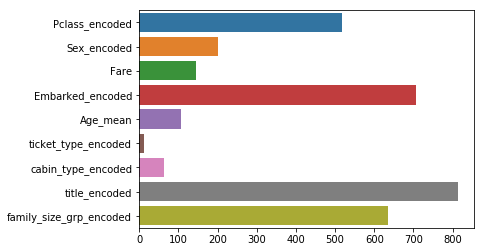

In [892]:
#feature importance curve
sns.barplot(estimator.feature_importances_, X_train.columns)
plt.show()

In [891]:
# Use the lgbm's predict method on the test data
y_pred = estimator.predict(X_validation)
print(confusion_matrix(y_validation, y_pred))
print(classification_report(y_validation, y_pred))
print(accuracy_score(y_validation, y_pred))

[[103   8]
 [ 17  51]]
             precision    recall  f1-score   support

          0       0.86      0.93      0.89       111
          1       0.86      0.75      0.80        68

avg / total       0.86      0.86      0.86       179

0.8603351955307262


C:\Users\abhay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unique_values = np.unique(values)


In [901]:
test=data_test_latest[['Pclass_encoded', 'Sex_encoded', 'Fare', 'Embarked_encoded', 'Age_mean', 'ticket_type_encoded', 'cabin_type_encoded', 'title_encoded', 'family_size_grp_encoded']]

In [902]:
test["Survived"]=estimator.predict(test)

C:\Users\abhay\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  unique_values = np.unique(values)
C:\Users\abhay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [903]:
test.to_csv("Submission8.csv")